In [1]:
#import libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#read train_clean csv
train_clean = pd.read_csv('../../data/train_clean.csv')

In [3]:
# explore the dataset
train_clean.head()

date                                            address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  species  block           street  trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              addressnumberandstreet   latitude  longitude  addressaccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   nummosquitos  wnvpresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

It looks like our target variable is 'wnvpresent'. Let's check if the classes are imbalanced.

### Checking for imbalanced classes

In [4]:
#checking for imbalanced classes
train_clean['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

It looks like the classes are quite imbalanced. The possible solutions would be to split the data into a stratified fashion during train test split or to smote the imbalanced class.  We will deal with the class imbalance when we fit our models later.

### Mosquito Species

In [5]:
#how many species of mosquitos are in the observations?

train_clean['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

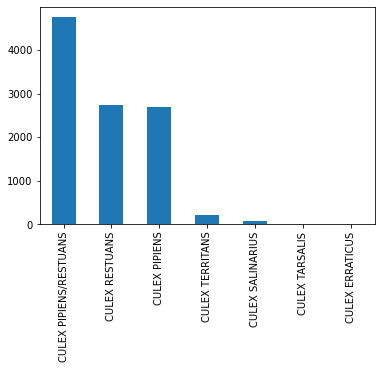

In [6]:
#how many mosquitos of each species are in the dataset?

train_clean['species'].value_counts(ascending=False).plot(kind='bar');

We can see that there are 7 species of mosquitos observed in the dataset. Out of which 3 species are observed more frequently than the others. Namely: Culex Pipiens/Restuans, Culex Restuans and Culex Pipiens. 

In [7]:
# which species of mosquitos carry the West Nile Virus?

train_clean.loc[train_clean['wnvpresent']==1]['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'],
      dtype=object)

In [8]:
# how many of these species carry the virus?
train_clean.loc[train_clean['wnvpresent']==1]['species'].value_counts(ascending=False)

CULEX PIPIENS/RESTUANS    262
CULEX PIPIENS             240
CULEX RESTUANS             49
Name: species, dtype: int64

<AxesSubplot:>

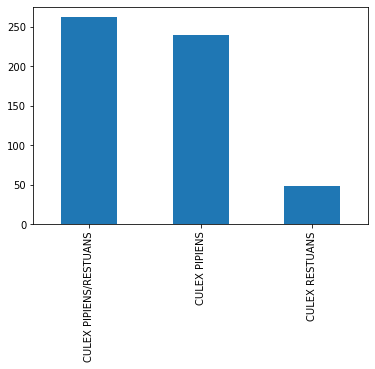

In [9]:
train_clean.loc[train_clean['wnvpresent']==1]['species'].value_counts(ascending=False).plot(kind="bar")

We can see that there are 3 species which carry the west nile virus, which coincidentally also have the highest number of observations compared to other mosquito species. For the purposes of modelling, we will be transforming species into an ordinal feature, based on proportion. 

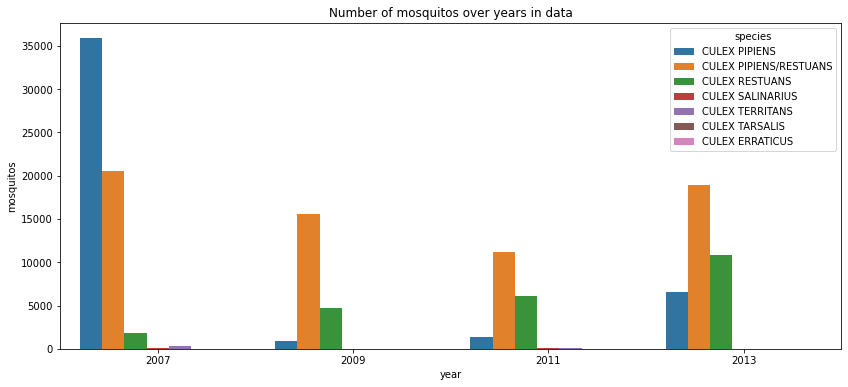

In [10]:
# mosquito population over the years
# charting mosquitos by year

train_clean['date'] = pd.to_datetime(train_clean['date'], format='%Y-%m-%d') #convert date to datetime object

train_clean['year'] = (train_clean['date'].dt.strftime('%Y')).astype(int) #create year column in dataset

mosq_by_yr = train_clean.groupby(['year', 'species'], as_index=False).sum().reindex()

plt.figure(figsize = (14,6))
plt.title('Number of mosquitos over years in data')
sns.barplot(x='year', y='nummosquitos', hue='species', data=mosq_by_yr)
plt.xlabel('year')
plt.ylabel('mosquitos'); 

Mosquito population was highest in the year 2007 with the species Culex Pipiens having the highest population. However, the overall mosquito population decreased in 2009 and 2011, and Culex Pipens/Restuans became the species with the highest population. 

In 2013, the population of mosquitos seem to have started increasing again.

### Traps

In [11]:
# how many traps are there?

train_clean['trap'].nunique()

136

In [12]:
#which traps have recorded the highest number of mosquitos?
train_clean.groupby(['trap', 'street'])['nummosquitos'].sum().sort_values(ascending=False)

trap  street             
T115   S DOTY AVE            21668
T900   W OHARE AIRPORT       15386
T138   S STONY ISLAND AVE     9936
T002   N OAK PARK AVE         3710
T128   E 105TH ST             3315
                             ...  
T072   S KEDZIE AVE             19
T237   W 85TH ST                18
T078   S RACINE AVE             17
T149   W GRANVILLE AVE          15
T040   S HAMLIN AVE              6
Name: nummosquitos, Length: 138, dtype: int64

<AxesSubplot:>

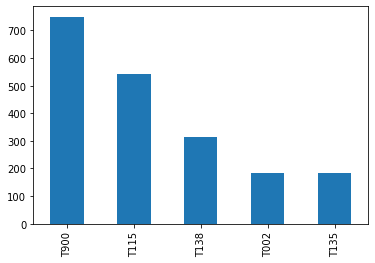

In [13]:
# which traps have been most sampled?  

train_clean['trap'].value_counts(ascending=False).head().plot(kind='bar')

Thus far, we see that S Doty Ave and W Ohare Airport seem to be the 2 most frequently sampled locations, and traps in these 2 locations (T115 and T900) have captured the highest number of mosquitos over the years.

## Preliminary feature combination and selection

There are 3 main steps in this process which we will need to do before combining the train dataset with other datasets for further EDA, feature selection and modelling. <br>

1) **Drop all address-related rows**: Retain latitude and longitude <br>
2) **Combine rows for same date, trap, species**: Sum up nummosquito over date & location & species <br>
3) **Group up species**: Make ordinal based on proportion of wnv within species <br>




### Drop address related rows

We have latitude, longitude and traps that are proxies/indicators of location. As such, we will remove the other address or location related features from the dataset.

In [14]:
address_features = ['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy']
train_clean.drop(columns=address_features,inplace=True)
train_clean.head()

date                 species  trap   latitude  longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   nummosquitos  wnvpresent  year  
0             1           0  2007  
1             1           0  2007  
2             1           0  2007  
3             1           0  2007  
4             4           0  2007

### Combining mosquito counts

We know that the dataset is organized such that the number of mosquitos captured is capped at 50 per record. Beyond 50, another row will be created for data collected on the same day. We will therefore explore combining the dataset rows together.

In [15]:
train_clean.loc[train_clean['nummosquitos']==50]

date                 species  trap   latitude  longitude  \
293   2007-07-11  CULEX PIPIENS/RESTUANS  T086  41.688324 -87.676709   
295   2007-07-11  CULEX PIPIENS/RESTUANS  T086  41.688324 -87.676709   
350   2007-07-11  CULEX PIPIENS/RESTUANS  T158  41.682587 -87.707973   
351   2007-07-11  CULEX PIPIENS/RESTUANS  T158  41.682587 -87.707973   
353   2007-07-11  CULEX PIPIENS/RESTUANS  T158  41.682587 -87.707973   
...          ...                     ...   ...        ...        ...   
10240 2013-09-12  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
10242 2013-09-12  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
10259 2013-09-12  CULEX PIPIENS/RESTUANS  T900  41.974689 -87.890615   
10262 2013-09-12  CULEX PIPIENS/RESTUANS  T900  41.974689 -87.890615   
10267 2013-09-12           CULEX PIPIENS  T900  41.974689 -87.890615   

       nummosquitos  wnvpresent  year  
293              50           0  2007  
295              50           0  2007  
350              50           0  2007  
351              50           0  2007  
353              50           0  2007  
...             ...         ...   ...  
10240            50           1  2013  
10242            50           0  2013  
10259            50           0  2013  
10262            50           0  2013  
10267            50           0  2013  

[1019 rows x 8 columns]

In [16]:
#combining rows

train_clean = train_clean.groupby([col for col in train_clean.columns if col not in ['nummosquitos']], as_index=False).sum().reindex()


### Group up species and convert species into ordinal features

Earlier, we mentioned that we will convert mosquito species into ordinal features by proportion.

<AxesSubplot:>

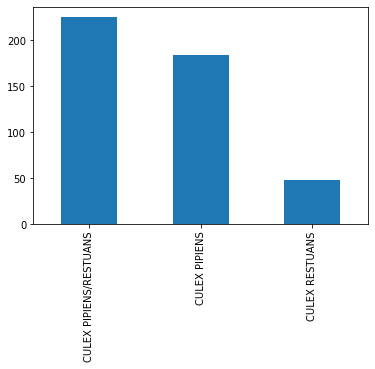

In [24]:
#recap of mosquito species carrying the west nile virus

train_clean.loc[train_clean['wnvpresent']==1]['species'].value_counts(ascending=False).plot(kind="bar")

Culex pipiens/restuans and Culex pipiens will take the value of 2 as they seem to have similar proportions in terms of carrying the west nile virus. Culex restuans will take the value of 1, and other mosquito species will take the value of 0.

In [28]:
train_clean['species_ord'] = train_clean['species'].map({'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1})

#0 for species other than the virus carriers
train_clean['species_ord'].fillna(0, inplace=True)

In [29]:
train_clean.head()

date                 species  trap   latitude  longitude  wnvpresent  \
0 2007-05-29           CULEX PIPIENS  T096  41.731922 -87.677512           0   
1 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991           0   
2 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812           0   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T048  41.867108 -87.654224           0   
4 2007-05-29  CULEX PIPIENS/RESTUANS  T050  41.919343 -87.694259           0   

   year  nummosquitos  species_ord  
0  2007             1          2.0  
1  2007             1          2.0  
2  2007             1          2.0  
3  2007             1          2.0  
4  2007             1          2.0

In [30]:
#save final train file to csv
train_clean.to_csv('../../data/train_eng_kev.csv')